In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/

/content/drive/My Drive


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn.model_selection import train_test_split
import urllib.request

urllib.request.urlretrieve("https://zenodo.org/record/3164691/files/QG_jets_10.npz", "QG_jets.npz")

('QG_jets.npz', <http.client.HTTPMessage at 0x7fa45a4ac550>)

# Task II: Classical Graph Neural Network (GNN) Part

Use ParticleNet’s data for Quark/Gluon jet classification. Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges. Discuss the resulting performance of the 2 chosen architectures.

## Overview of the Dataset


The input file has 100k jets, exactly 50k quark and 50k gluon jets, randomly sorted. Every jet in the file contains  M  x  F  data where  M  is the maximum number of multiplicity of the jets in the file and  F  is the number of each particle's features (pt, rapidity, azimuthal angle, and Particle Data Group ID).

## Graph-Based Architectures for Jet Classification: Selection and Considerations



For this task, we will be using the Jet Classifciation[ paper](https://arxiv.org/abs/1902.08570) model of Particle-Net Lite and its code for jet classification. 

In [ ]:
df = np.load('QG_jets.npz')
lst = df.files
print(list(df.keys()))

['X', 'y']


To enable the use of a softmax activation function used at the end of the ParticleNet-Lite networks, which is necessary for classification, the labels must be transformed into a one-hot format. This ensures that the output of the network represents the probability of the input particle belonging to each class, with a total probability of 1.0.

In [ ]:
# Extract data as per keys
x = df['X']
y = df['y']

# Transform the labels to one-hot format
y = tf.keras.utils.to_categorical(y)

num_samples = x.shape[0]
num_particles = x.shape[1]
num_features = x.shape[2]
print("Total number of samples:", num_samples)
print("Maximum number of particles in a jet:", num_particles)
print("Number of features:", num_features)

Total number of samples: 100000
Maximum number of particles in a jet: 138
Number of features: 4


### Preprocessing

In the paper, dataset consisting of 2 million jets is split into 1.6M/200k/200k for training, validation and testing. So we follow similar 80/10/10 splitting.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=21)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(80000, 138, 4) (80000, 2)
(10000, 138, 4) (10000, 2)
(10000, 138, 4) (10000, 2)


The model takes three input arrays:

points: the coordinates of the particles in the (eta, phi) space. It should be an array with a shape of (N, P, 2), where N is the batch size and P is the number of particles.

features: the features of the particles. It should be an array with a shape of (N, P, C), where N is the batch size, C is the number of features, and P is the number of particles.

mask: a mask array with a shape of (N, P, 1), taking a value of 0 for padded positions.


In [ ]:
train_set = {
    # the coordinates of the particles in the (eta, phi) space
    'points': x_train[:, :, 1:3],
    # the features of the particles 
    'features': x_train,
    # a mask array, taking a value of 0 for padded positions
    'mask': np.array(np.sum(x_train, axis=2) != 0, np.float32).reshape(len(x_train), num_particles, 1)
}

val_set = {
    'points': x_val[:, :, 1:3],
    'features': x_val,
    'mask': np.array(np.sum(x_val, axis=2) != 0, np.float32).reshape(len(x_val), num_particles, 1)
}

test_set = {
    'points': x_test[:, :, 1:3],
    'features': x_test,
    'mask': np.array(np.sum(x_test, axis=2) != 0, np.float32).reshape(len(x_test), num_particles, 1)
}

In [ ]:
input_shape = {k:train_set[k].shape[1:] for k in train_set}
input_shape

{'points': (138, 2), 'features': (138, 4), 'mask': (138, 1)}

### ParticleNet-Lite Architecture

#### About the architecture

The ParticleNet-Lite architecture used here consists of two EdgeConv blocks. The first EdgeConv block uses the spatial coordinates
of the particles in the pseudorapidity-azimuth space to
compute the distances, while the subsequent blocks use
the learned feature vectors as coordinates. The number
of nearest neighbors k is 7 for all three blocks, and the
number of channels C for each EdgeConv block is (32, 32, 32) and (64,
64, 64) respectively. After the EdgeConv blocks, a channel-wise global average pooling operation is applied to aggregate the learned features over all particles in the cloud. This is followed by
a fully connected layer with 128 units and the ReLU activation. A dropout layer with a drop probability of
0.1 is included to prevent overfitting. A fully connected
layer with two units, followed by a softmax function, is
used to generate the output for the binary classification.

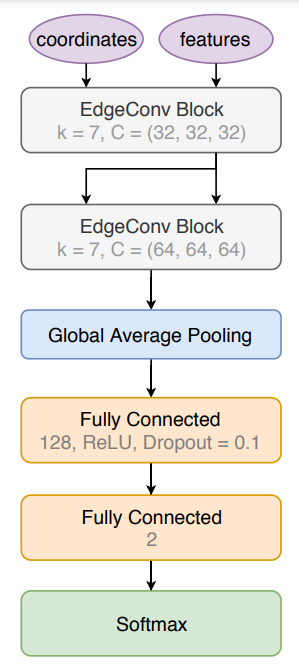

#### Implementation

In [ ]:
import tf_keras_model
from tf_keras_model import get_particle_net_lite

num_classes = 2
model = get_particle_net_lite(num_classes, input_shape)

In [ ]:
import logging
logging.basicConfig(level=logging.INFO,
                    format='[%(asctime)s] %(levelname)s: %(message)s')
# Training parameters
batch_size = 1024
epochs = 25
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f' % lr)
    return lr
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mask (InputLayer)              [(None, 138, 1)]     0           []                               
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 138, 1)      0           ['mask[0][0]']                   
                                                                                                  
 tf.cast (TFOpLambda)           (None, 138, 1)       0           ['tf.math.not_equal[0][0]']      
                                                                                                  
 tf.math.equal (TFOpLambda)     (None, 138, 1)       0           ['tf.cast[0][0]']                
                                                                                        

In [ ]:
import os
save_dir = 'model_checkpoints'
model_name = '%s_model.{epoch:03d}.h5' % 'particle_net_lite'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                                             monitor='val_accuracy',
                                             verbose=1,
                                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler, progress_bar]
history = model.fit(train_set, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(val_set, y_val),
                    shuffle=True,
                    callbacks=callbacks)

Epoch 1/100
      0/Unknown - 490s 0s/sample - loss: 0.5310 - accuracy: 0.7362
Epoch 1: val_accuracy improved from -inf to 0.60640, saving model to model_checkpoints/particle_net_lite_model.001.h5
79/79 [==============================] - 504s 6s/sample - loss: 0.5310 - accuracy: 0.7362 - val_loss: 0.6167 - val_accuracy: 0.6064 - lr: 0.0010
Epoch 2/100
 0/79 [..............................] - ETA: 0s - loss: 0.4794 - accuracy: 0.7765
Epoch 2: val_accuracy improved from 0.60640 to 0.74290, saving model to model_checkpoints/particle_net_lite_model.002.h5
79/79 [==============================] - 496s 6s/sample - loss: 0.4794 - accuracy: 0.7765 - val_loss: 0.5353 - val_accuracy: 0.7429 - lr: 0.0010
Epoch 3/100
 0/79 [..............................] - ETA: 0s - loss: 0.4711 - accuracy: 0.7845
Epoch 3: val_accuracy improved from 0.74290 to 0.77000, saving model to model_checkpoints/particle_net_lite_model.003.h5
79/79 [==============================] - 490s 6s/sample - loss: 0.4711 - accuracy

#### Evaluation

In [ ]:
import json
import matplotlib.pyplot as plt
with open("particle_net_lite_history.json", "w") as outfile:
    outfile.write(str(history.history))

In [ ]:
result = model.evaluate(test_dataset, y_test)
print("test loss, test acc:", result)

test loss, test acc: [0.5085463461276892, 0.7416348924512864]

### Code Summary

We used the ParticleNet-Lite model for Jet Classification. The training loss decreases over epochs and also the training accuracy increases which means the model fits the data. However, the validation loss and accuracy becomes nearly constant after near 20th epoch which shows the overfitting. The training accuracy is near 81% which is comparable to the results of the paper Jet tagging via particle clouds.